<a href="https://colab.research.google.com/github/Satbeul11/horizon_detection/blob/main/Fast_horizon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ 전체 알고리즘 파이프라인 (Jeong et al., 2018 기준)

1. ROI 탐색 (입력 이미지를 1/4로 축소 후 수평 슬라이스 간 색 변화 측정)

2. ROI 기준 원본 이미지에서 Multi-scale Median Filtering → Canny Edge Detection

3. 모든 스케일의 엣지를 가중합한 후 thresholding

4. Hough Transform으로 초기 수평선 후보 검출

5. Median filtering으로 outlier 제거 → Least Squares로 최종 직선 계산

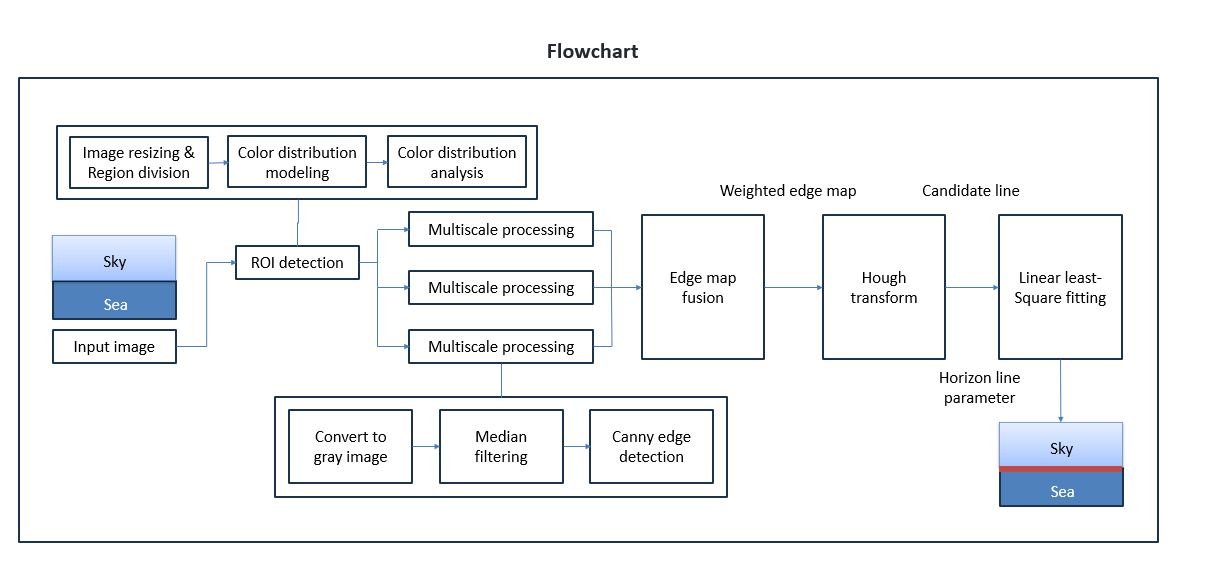

🛠️ 필요한 라이브러리

In [ ]:
import cv2
import numpy as np
from scipy.spatial.distance import mahalanobis
from skimage.transform import hough_line, hough_line_peaks
from sklearn.linear_model import LinearRegression

📌 [1] ROI 탐색 핵심 로직 요약
1. 입력 이미지를 축소 (1/4 크기 정도)

2. 수평 방향으로 겹치게 잘라서 N개 영역 분할 (50% overlap)

3. 각 영역의 평균 색과 공분산 계산

4. 이웃한 두 영역 간 Bhattacharyya 거리 계산

5. 가장 거리 큰 위치를 ROI 중심으로 **선택**

🧪 예시 파라미터
- 축소 비율: 0.25

- 수평 분할 수: N = 9

- 각 영역은 50% 중첩

In [ ]:
# ✨ 구현 함수 설계

def detect_roi(image, num_regions=9, scale=0.25):
    import cv2
    import numpy as np

    # Step 1: Resize image
    resized = cv2.resize(image, (0, 0), fx=scale, fy=scale)

    h, w, _ = resized.shape
    region_height = h // (num_regions + 1) # 10개로 자름


    # Step 2: Create overlapping horizontal slices
    regions = []
    for i in range(num_regions):
        y_start = int(i * region_height * 0.5)
        y_end = y_start + region_height
        regions.append(resized[y_start:y_end, :, :])

    # Step 3: Calculate Bhattacharyya distance between each pair
    def bhattacharyya(m1, c1, m2, c2):
        diff = m1 - m2
        cov = (c1 + c2) / 2.0
        return np.sqrt(0.25 * diff.T @ np.linalg.pinv(cov) @ diff)

        # 공분산은 어떻게 구하는가?

    distances = []
    for i in range(len(regions) - 1):
        r1 = regions[i].reshape(-1, 3) # reshape(-1,3)은 h,w의 2차원을 1차원으로 만들고, '3'이 rgb 3채널
        r2 = regions[i+1].reshape(-1, 3)
        m1, c1 = np.mean(r1, axis=0), np.cov(r1, rowvar=False) # axis=0은 열(RGB각각) 평균, 각각(mR, mG, mB)
        m2, c2 = np.mean(r2, axis=0), np.cov(r2, rowvar=False)
        dist = bhattacharyya(m1, c1, m2, c2)
        distances.append(dist)

        """
        공분산 np.cov(...) 의 결과
        [[var_R, cov_RG, cov_RB],
 [cov_GR, var_G, cov_GB],
 [cov_BR, cov_BG, var_B]]
        """

    # Step 4: Max distance region index → ROI center
    max_idx = np.argmax(distances)
    y_start = int(max_idx * region_height * 0.5 / scale) # 원본이미지 기준으로 박스 > scale로 나눔
    y_end = int((y_start + region_height / scale))

    roi_box = (y_start, y_end)  # top and bottom in original image
    return roi_box

In [ ]:
# 📷 ROI 시각화 코드(선택)

import cv2
import matplotlib.pyplot as plt

def visualize_roi(image, roi_box):
    y1, y2 = roi_box
    vis_image = image.copy()

    # ROI 사각형 그리기 (전체 너비)
    cv2.rectangle(vis_image, (0, y1), (image.shape[1], y2), (0, 0, 255), 2)

    # BGR → RGB 변환 후 출력
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected ROI")
    plt.axis('off')
    plt.show()

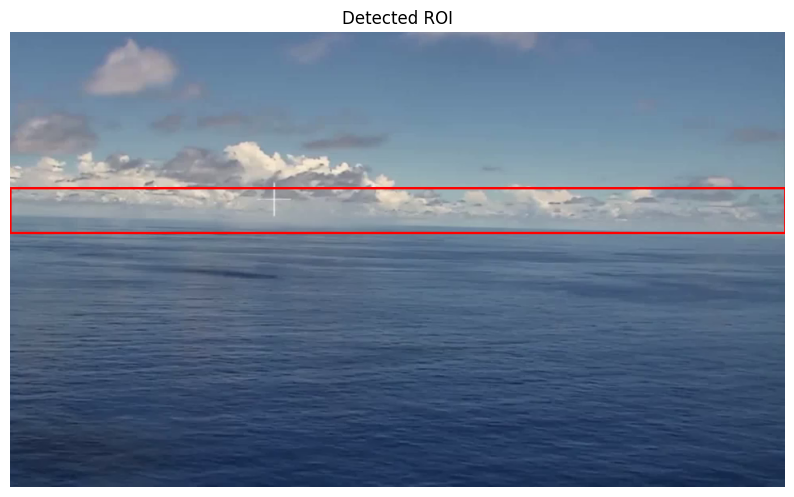

In [ ]:
# ✅ 사용 예시(선택)

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/horizon_detect/01_001.png')  # 이미지 로드
roi_box = detect_roi(image)
visualize_roi(image, roi_box)

[2] ROI 기준 원본 이미지에서 Multi-scale Median Filtering → Canny Edge Detection

✅ 목표: generate_multiscale_edges(roi_image) 함수

🔧 입력:
roi_image: 원본 이미지에서 잘라낸 ROI 영역

⚙️ 처리:
Median filter를 다양한 커널 크기로 적용 (예: 3×3, 5×5, 7×7)

각 필터 결과에 Canny edge 검출

결과를 리스트로 반환

📦 출력:
edge_list: 각 스케일에서 얻은 edge map들의 리스트

In [ ]:
# 🧠 구현 예시

def generate_multiscale_edges(roi_image, kernel_sizes=[5, 7, 11]):
    import cv2

    edge_list = []

    for k in kernel_sizes:
        # Median filter
        blurred = cv2.medianBlur(roi_image, k)

        # 그레이스케일 변환
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

        # Histogram Equalization
        equalized = cv2.equalizeHist(gray)

        # Canny edge
        edges = cv2.Canny(gray, 30, 100)
        edge_list.append(edges)

    return edge_list

In [ ]:
# 🧪 사용 예시

# ROI padding
margin = 20
y1 = max(roi_box[0] - margin, 0)
y2 = min(roi_box[1] + margin, image.shape[0])
roi = image[y1:y2, :]

edge_maps = generate_multiscale_edges(roi)

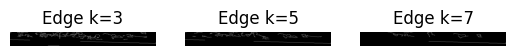

In [ ]:
# 🖼️ 참고로 시각화하고 싶다면?

import matplotlib.pyplot as plt

for i, edge in enumerate(edge_maps):
    plt.subplot(1, len(edge_maps), i+1)
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Edge k={ [3,5,7][i] }')
    plt.axis('off')
plt.show()

# 7/17(목) 여기까지 공부함 위에 다시 읽어야함

[3]
✅ 다음 단계: 엣지맵 가중합 + 임계값 필터링
👉 목적
여러 스케일의 edge map을 하나의 edge map으로 결합

약한 노이즈 edge는 제거하고 수평선 edge만 강조

In [ ]:
# 🧠 이어서 구현할 함수

def combine_and_threshold_edges(edge_list, threshold=170):
    import numpy as np
    # edge_list는 각 스케일의 이진 edge map (0 또는 255)
    weighted = np.zeros_like(edge_list[0], dtype=np.float32)

    for edge in edge_list:
        weighted += edge.astype(np.float32)

    # 정규화 없이 임계값 적용 (255 이상이면 강한 edge임)
    combined = np.where(weighted >= threshold, 255, 0).astype(np.uint8)
    return combined

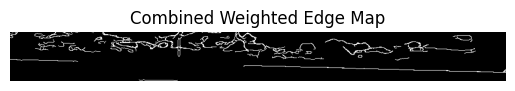

In [ ]:
# ✅ 사용 예시

combined_edge = combine_and_threshold_edges(edge_maps, threshold=170)

plt.imshow(combined_edge, cmap='gray')
plt.title("Combined Weighted Edge Map")
plt.axis('off')
plt.show()

[4,5] ✅ 전체 흐름 요약
Hough Transform: 전체 edge map에서 직선 후보를 검출

Median Filter: outlier edge 제거

Least Squares: 남은 inlier edge를 기반으로 직선 방정식 추정

In [ ]:
# 🧠 함수 구현

def estimate_horizon_line(edge_map):
    import numpy as np
    import cv2
    from sklearn.linear_model import LinearRegression

    # Step 1: find non-zero (edge) points
    y_coords, x_coords = np.nonzero(edge_map)

    if len(x_coords) < 2:
        return None  # edge가 너무 적음

    # Step 2: median filtering (outlier 제거)
    # residual이 큰 점 제거
    X = x_coords.reshape(-1, 1)
    y = y_coords
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    residual = np.abs(y - y_pred)
    threshold = np.median(residual) * 1.5
    inlier_mask = residual < threshold

    X_inlier = X[inlier_mask]
    y_inlier = y[inlier_mask]

    # Step 3: Least Squares (최종 직선)
    if len(X_inlier) < 2:
        return None  # 유효한 직선 불가
    final_model = LinearRegression().fit(X_inlier, y_inlier)
    slope = final_model.coef_[0]
    intercept = final_model.intercept_

    return slope, intercept

In [ ]:
# 🖼️ 시각화 함수

def draw_horizon(image, slope, intercept, color=(0, 0, 255), thickness=2):
    h, w = image.shape[:2]
    x1, x2 = 0, w
    y1 = int(slope * x1 + intercept)
    y2 = int(slope * x2 + intercept)

    vis = image.copy()
    cv2.line(vis, (x1, y1), (x2, y2), color, thickness)
    return vis

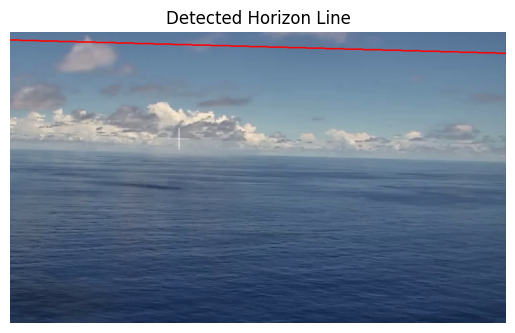

In [ ]:
# ✅ 사용 예시

result = estimate_horizon_line(combined_edge)

if result is not None:
    slope, intercept = result

    # ⬇️ 이 줄을 꼭 추가하세요!
    adjusted_intercept = intercept + y1  # ← padding 포함된 ROI의 시작 y좌표

    vis = draw_horizon(image, slope, intercept)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Detected Horizon Line")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ 수평선 추정 실패: edge가 부족합니다.")

디버깅

In [ ]:
print("Before adjustment:", intercept)
print("y1 offset:", y1)
print("After adjustment:", intercept + y1)

Before adjustment: 17.640809758910486
y1 offset: 176
After adjustment: 193.64080975891048


In [ ]:
print("slope:", slope)


slope: 0.027152859964236095


In [ ]:
print("ROI shape:", roi.shape)
print("y1 (padding 포함):", y1)


ROI shape: (96, 970, 3)
y1 (padding 포함): 176


In [ ]:
print("Fitted intercept (ROI 기준):", intercept)


Fitted intercept (ROI 기준): 17.640809758910486
